<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute metrics across cross-validation fold predictions .csv files

In [10]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

In [11]:
import numpy as np
import os
import pandas as pd
# Es indistinto usar las métricas de scikit learn o tensorflow
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from matplotlib import pyplot as plt

In [12]:
if isGoogleColab():
    %cd -q '/content'
    if os.path.exists('fluence_maps'):
        !rm -fr fluence_maps

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    %cd -q '/content/fluence_maps'

    !ls -l '/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/predictions'
    
    ARG_PREDICTIONS_FILES_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/predictions'

In [13]:
def display_scatterplot(model_name, y, y_hat):
    print('Model name = %s' % model_name)
    print('size = %d' % len(y))

    # mean average error
    mae = mean_absolute_error(y, y_hat)
    print('MAE = %.3f' % (mae))

    # mean square error
    mse = mean_squared_error(y, y_hat)
    print('MSE = %.3f' % (mse))
    
    # correlación entre predichos y observados
    corr = np.corrcoef(y, y_hat)[0,1]
    print('Pearson correlation = %.3f' % (corr))

    r2score = r2_score(y, y_hat)
    print('R-squared = %.3f' % (r2score))
    
    # plot calculados vs. predichos (targets)
    fig_dims = (8, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.title('Actual vs. Predicted')
    plt.gca().set_aspect('equal')
    sns.scatterplot(y, y_hat, marker='o', ax=ax)
    ax.set(xlabel="Actual", ylabel = "Predicted")
    plt.figure(figsize=(15, 15))
    minimum = int(np.min([y.min(), y_hat.min()]))
    ax.set_xlim([minimum, 100])
    ax.set_ylim([minimum, 100])
    ax.plot([minimum, 100], [minimum, 100], ls="--", c=".7")
    ax.plot([minimum+3, 100], [minimum, 97], ls="--", c=".4")
    ax.plot([minimum, 97], [minimum+3, 100], ls="--", c=".4")
    plt.show()

In [14]:
#============================DEFINE YOUR ARGUMENTS==============================
if not isGoogleColab():
    # base data directory
    ARG_PREDICTIONS_FILES_DIR='/hdd/data/radioterapia/ciolaplata/predictions'

# To display in the scatter plot
# ARG_MODEL_NAME = '2019+2017 ResNet18+BN cross-validation'
# ARG_MODEL_NAME = '2019+2017 Ensemble (VGG16, ResNet18 with BN, MobileNetV2) cross-validation'
# ARG_MODEL_NAME = '2019+2017 MobileNetV2 cross-validation'
ARG_MODEL_NAME = '2019+2017 Ensemble (ResNet18 with BN, MobileNetV2) cross-validation'
# file name example: predicted_gamma_1612479698.23456.validation.csv
vgg16 = {
    0: '1612494638.23456',
    1: '1612496273.23456',
    2: '1612497448.23456',
    3: '1612498850.23456',
    4: '1612499915.23456'
}
resnet18 = {
    0: '1612475423.23456',
    1: '1612476739.23456',
    2: '1612478852.23456',
    3: '1612485107.23456',
    4: '1612485908.23456'
}
resnet18bn = {
    0: '1612481240.23456',
    1: '1612480461.23456',
    2: '1612479698.23456',
    3: '1612482315.23456',
    4: '1612483273.23456'
}

mobilenetv2 = {
    0: '1612656464.mobilenetV2.23456',
    1: '1612650230.mobilenetV2.23456',
    2: '1612652753.mobilenetV2.23456',
    3: '1612653996.mobilenetV2.23456',
    4: '1612655112.mobilenetV2.23456',
}

# this is a single model
ARG_MODEL_PREDICTIONS = mobilenetv2

# this is an ensemble of models
# (vgg16, resnet18bn) es el mejor ensamble
ARG_MODEL_PREDICTIONS = (vgg16, mobilenetv2, resnet18bn)

In [15]:
pd.options.display.max_colwidth = 120

In [16]:
def get_model_predictions(model_predictions, path):
    files = [f'predicted_gamma_{model_predictions[fold]}.validation.csv' for fold in model_predictions]
    
    df_all = pd.DataFrame()
    for file in files:
        full_filename = os.path.join(path, file)
        df = pd.read_csv(full_filename, header=0)
        print(f'predictions file {full_filename} has {len(df)} rows.')
        df_all = df_all.append(df)
    return df_all

predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612494638.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612496273.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612497448.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612498850.23456.validation.csv has 853 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612499915.23456.validation.csv has 853 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612656464.mobilenetV2.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612650230.mobilenetV2.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612652753.mobilenetV2

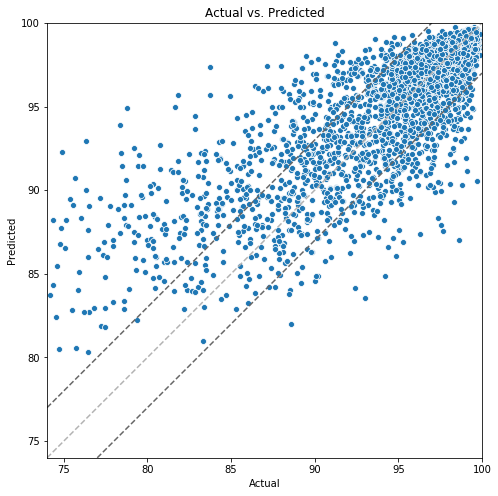

<Figure size 1080x1080 with 0 Axes>

In [17]:
if type(ARG_MODEL_PREDICTIONS)==tuple:
    df1 = get_model_predictions(ARG_MODEL_PREDICTIONS[0], ARG_PREDICTIONS_FILES_DIR)
    df2 = get_model_predictions(ARG_MODEL_PREDICTIONS[1], ARG_PREDICTIONS_FILES_DIR)
    df3 = get_model_predictions(ARG_MODEL_PREDICTIONS[2], ARG_PREDICTIONS_FILES_DIR)
    
    # print('First map in each fold in first model')
    # df1['filename'][0]  
    # print('First map in each fold in second model')
    # df2['filename'][0]    
    
    # check
    check = all(df1['filename'][223]==df2['filename'][223])
    assert check, 'predictions are not aligned in across models'

    y = df1['actual gamma'] # el actual es igual en cualquiera de los modelos :-)
    # y_hat = (df1['predicted gamma'] + df2['predicted gamma'])/2
    y_hat = (df1['predicted gamma'] + df2['predicted gamma'] + df3['predicted gamma'])/3

else:
    df = get_model_predictions(ARG_MODEL_PREDICTIONS, ARG_PREDICTIONS_FILES_DIR)
    y = df['actual gamma']
    y_hat = df['predicted gamma']
    
display_scatterplot(ARG_MODEL_NAME, y, y_hat)

In [18]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')